In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel, FluxInpaintPipeline
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
import sys
from pathlib import Path
import helper_plot_hangul
import importlib
import gc
import logging
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict, Any
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from helper_dev_utils import *
from diffusers.utils import load_image
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    logger.debug("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    logger.debug("✓ Manual login completed")

2026-01-17 08:08:24 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


2026-01-17 08:08:24 D [ipykernel_launcher:10] - ✓ Logged in with HF_TOKEN from environment


In [4]:
import sys
from pathlib import Path

# 프로젝트 경로 설정
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
sys.path.insert(0, str(project_root))
logger.debug(project_root)

import torch
import gc
from PIL import Image
from typing import Optional

from diffusers import DiffusionPipeline
from config import TORCH_DTYPE
from services.monitor import flush_gpu


2026-01-17 08:08:24 D [ipykernel_launcher:7] - /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [5]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE, MODEL_IDS
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        # 마스크 블러 처리 (외곽선 부드럽게)
        from PIL import ImageFilter
        mask = mask.filter(ImageFilter.GaussianBlur(radius=5))
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask


In [6]:
"""
공간 및 객체 정밀 분석 모듈: Qwen2-VL을 사용한 단계별 이미지 분석 및 FLUX.1 프롬프트 생성
Spatial & Object Analyzer: Step-by-Step Analysis using Qwen2-VL for FLUX.1
"""

import torch
from PIL import Image, ImageDraw
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from typing import Union, Dict, List, Tuple
import re

from utils import flush_gpu

class SpatialAnalyzer:
    """
    Qwen2-VL을 사용하여 이미지를 분석하고 FLUX.1용 최적화 프롬프트를 생성하는 클래스.
    '단계별 추론(Chain of Thought)'을 통해 건어물, 과일, 공산품 등의 질감을 정확히 잡아냅니다.
    """

    def __init__(self, model_name: str = "Qwen/Qwen2-VL-7B-Instruct", device: str = None):
        self.model_name = model_name
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.processor = None
        logger.debug(f"SpatialAnalyzer 초기화 설정: {model_name} ({self.device})")

    def _load_model(self):
        """모델 로드 (이미 로드되어 있으면 생략)"""
        if self.model is None:
            logger.debug(f"Qwen2-VL 모델 로딩 중... ({self.device})")
            self.model = Qwen2VLForConditionalGeneration.from_pretrained(
                self.model_name,
                torch_dtype=torch.bfloat16 if self.device == "cuda" else torch.float32,
                device_map="auto" if self.device == "cuda" else None,
            )
            # CPU 강제 할당인 경우
            if self.device == "cpu":
                self.model.to("cpu")
                
            self.processor = AutoProcessor.from_pretrained(self.model_name)
            logger.debug("모델 로드 완료")

    def _unload_model(self):
        """VRAM 확보를 위한 모델 언로드"""
        if self.model is not None:
            logger.debug("모델 언로드 및 메모리 정리 중...")
            del self.model
            del self.processor
            self.model = None
            self.processor = None
            flush_gpu()

    def _run_inference(self, image, query, max_tokens=256):
        """내부 추론 실행 헬퍼 함수"""
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": query},
                ],
            }
        ]
        
        # 입력 전처리
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        ).to(self.device)

        # 생성
        with torch.no_grad():
            generated_ids = self.model.generate(
                **inputs, 
                max_new_tokens=max_tokens,
                temperature=0.2, # 분석의 정확성을 위해 낮은 온도 사용
                top_p=0.9
            )

        # 디코딩
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = self.processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)[0]
        return output_text

    def generate_progressive_prompt(
        self,
        image: Union[Image.Image, str],
        language: str = "ko",
        auto_unload: bool = True,
    ) -> Dict[str, str]:
        """
        [핵심 기능] 2단계 분석 프로세스
        1. 분류(Category): 이것이 무엇인가? (예: 건어물, 과일, 기계)
        2. 정밀 묘사(Detail): 해당 분야 전문가 프롬프트를 사용하여 텍스처와 형태를 분석
        """
        try:
            self._load_model()
            
            # 이미지 로드
            if isinstance(image, str):
                image = Image.open(image).convert("RGB")
            
            logger.debug("[Step 1] 대상 식별 및 분류 시작...")
            
            # 1단계 질문: 대분류 식별
            identify_query = (
                "Identify the main subject. Choose one category: "
                "'Dried Seafood', 'Fresh Fruit', 'Cooked Dish', 'Inorganic Object', 'Nature/Landscape'. "
                "Then, name the specific species or object if possible (e.g., 'Young Pollack', 'Banana'). "
                "Output format: Category | Specific Name"
            )
            
            # 1차 추론
            cat_result = self._run_inference(image, identify_query, max_tokens=64)
            logger.debug(f"식별 결과: {cat_result}")

            # 2단계: 전문가 프롬프트 선택
            expert_query = self._select_expert_prompt(cat_result, language)
            
            logger.debug("\n🔬 [Step 2] 전문가 페르소나 정밀 분석 시작...")
            
            # 2차 추론 (Deep Dive)
            detail_result = self._run_inference(image, expert_query, max_tokens=512)
            
            # 결과 정제
            final_prompt = self._refine_prompt(detail_result)
            
            logger.debug(f"최종 프롬프트 생성 완료 (길이: {len(final_prompt)})")
            
            return {
                "step1_category": cat_result,
                "prompt": final_prompt,
                "raw_response": detail_result
            }

        finally:
            if auto_unload:
                self._unload_model()

    def _select_expert_prompt(self, category_info: str, language: str) -> str:
        """
        식별된 카테고리에 따라 최적의 분석 프롬프트를 반환하는 'Switch-Case' 로직
        """
        category_lower = category_info.lower()
        
        # --- 케이스 1: 건어물 / 해산물 (Dried Seafood) ---
        # 논의했던 '보수적 관찰' 및 '기름기 제거' 로직이 포함됨
        if any(x in category_lower for x in ['dried', 'seafood', 'fish', 'pollack', 'nogari', 'anchovy', 'squid', 'jerky']):
            logger.debug("모드 감지: [건어물 전문가 모드] 실행")
            return (
                "Act as a 'Forensic Seafood Taxonomist'. Your goal is to generate tag-based keywords for FLUX.1. "
                "1. SPECIES ID: Check tail shape (V-shape?) and skin pattern. Identify if it is 'Dried Young Pollack (Nogari)', 'Filefish (Jwipo)', or 'Dried Squid'. "
                "2. STATE CHECK (Critical): Force modifiers like 'Dried', 'Dehydrated', 'Roast'. "
                "3. TEXTURE PHYSICS: Is it 'Matte'? 'Fibrous'? 'Parchment-like'? "
                "   **CONSTRAINT**: Do NOT describe it as 'Oily' or 'Glossy' unless wet. Use 'Satin finish' for dry sheen. "
                "4. SHAPE: 'Headless torso', 'Flattened/Pressed', 'Shriveled'. "
                "Output Format: A structured list of comma-separated tags starting with the identified species."
                if language == "en" else
                "해산물 법의학 분석가로 행동하세요. FLUX.1을 위한 태그 리스트를 생성해야 합니다. "
                "1. 어종 식별: 꼬리(V자형?)와 껍질을 보고 '말린 노가리', '쥐포', '오징어' 등을 구별하세요. "
                "2. 상태 강제(필수): '건조된', '탈수된', '구운' 수식어를 반드시 붙이세요. "
                "3. 질감 물리학: '매트한', '섬유질', '양피지 같은'. "
                "   **제약사항**: 젖어있지 않다면 절대 '기름진', '광택' 표현을 쓰지 마세요. 대신 '은은한 윤기'를 쓰세요. "
                "4. 형태: '머리 없는 몸통', '납작하게 눌린', '쪼그라든'. "
                "출력 형식: 식별된 어종으로 시작하는 쉼표로 구분된 태그 리스트만 출력하세요."
            )

        # --- 케이스 2: 과일 / 식물 (Organic/Fruit) ---
        elif any(x in category_lower for x in ['fruit', 'vegetable', 'banana', 'apple', 'plant']):
            logger.debug("모드 감지: [식물 세밀화가 모드] 실행")
            return (
                "Act as a 'Botanical Illustrator'. "
                "Identify variety and ripeness (e.g., 'Ripe Cavendish Banana with sugar spots'). "
                "Describe skin texture ('Waxy', 'Porous', 'Fuzzy'). "
                "List specific defects like bruises or brown spots. "
                "Output as comma-separated tags."
            )
            
        # --- 케이스 3: 공산품 / 무기물 (Synthetic) ---
        elif any(x in category_lower for x in ['plastic', 'metal', 'glass', 'inorganic', 'bottle', 'phone']):
            logger.debug("모드 감지: [산업 재질 분석가 모드] 실행")
            return (
                "Act as a 'Industrial Material Analyst'. "
                "Analyze the surface finish: 'Glossy', 'Brushed Metal', 'Matte Plastic'. "
                "Look for manufacturing details: 'Seams', 'Mold lines', 'Uniform reflection'. "
                "Output as comma-separated tags."
            )

        # --- 케이스 4: 기본값 (Fallback) ---
        else:
            logger.debug("모드 감지: [일반 시각 분석가 모드] 실행")
            return (
                "Act as a 'Visual Texture Analyst'. "
                "Describe the object's geometry, material physics (matte vs glossy), and surface details based on visible pixels. "
                "Output specific keyword tags for image generation."
            )

    def _refine_prompt(self, text: str) -> str:
        """모델 응답에서 불필요한 서술어를 제거하고 태그만 남김"""
        # 불필요한 문장 제거
        clean_text = re.sub(r"Here is the list.*?:", "", text, flags=re.IGNORECASE)
        clean_text = re.sub(r"Based on the image.*?:", "", clean_text, flags=re.IGNORECASE)
        return clean_text.strip()



In [7]:
from models.flux_generator import FluxGenerator

fluxgenerator = FluxGenerator()
segmenter = SegmentationModel()
analyzer = SpatialAnalyzer()
logger.debug("로딩 성공")

2026-01-17 08:08:25 I [flux_generator:37] - FluxGenerator initialized (pipelines will load on demand)
2026-01-17 08:08:25 D [ipykernel_launcher:26] - SpatialAnalyzer 초기화 설정: Qwen/Qwen2-VL-7B-Instruct (cuda)
2026-01-17 08:08:25 D [ipykernel_launcher:6] - 로딩 성공


In [8]:
product_fg, product_mask = segmenter.run(Image.open("image01.png"))

2026-01-17 08:08:25 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


In [ ]:
resutl = analyzer.generate_progressive_prompt("image01.png", detail_level="ultra")
logger.info(resutl['prompt'])

In [ ]:
prompt="""A detailed, photorealistic close-up shot on a worn wooden pub table. Two glasses of Korean draft beer are central. On the left, a tall, slender pilsner glass for a woman, filled with golden beer and a thick foam head. On the right, a robust, handled glass mug for a man, also filled. Both glasses are heavily covered in cold condensation and realistic water droplets streaking down the sides, pooling slightly on the table. The labels on the glasses are partially obscured by moisture but suggest popular Korean brands like 'Cass' or 'Terra'. In the background, out of focus, a lively, warm-lit Korean pub (pocha) interior with blurred patrons, metal chopsticks, and small snack dishes. Natural bar lighting, highly textured, cinematic quality, 8k resolution."""
image = fluxgenerator.generate_background(f"{resutl['prompt']}")
analyzer._unload_model()
image.show()

In [ ]:
# 2. 흐린 한국 맥주집 배경 생성 (만화풍)
background_prompt = """
A blurred, dreamy illustration of a cozy Korean beer pub (pocha) interior. 
Cartoon style, anime aesthetic, soft focus background with warm ambient lighting. 
Blurred hanging lanterns, wooden tables, and traditional decorations. 
Empty foreground space for product placement. 
Bokeh effect, shallow depth of field, cinematic atmosphere, 8k illustration.
"""

bg_image = fluxgenerator.generate_background(
    prompt=background_prompt,
    guidance_scale=3.5,
    seed=42,
    auto_unload=False
)


2026-01-17 08:08:31 I [flux_generator:141] - [FluxGenerator] Generating background with Text-to-Image...
2026-01-17 08:08:31 I [flux_generator:60] - [FluxGenerator] Loading FLUX Text-to-Image pipeline...
2026-01-17 08:08:31 I [flux_generator:44] - [FluxGenerator] Loading 8bit quantized Transformer...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-17 08:10:13 I [flux_generator:52] - [FluxGenerator] Transformer loaded with 8bit quantization


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 08:10:20 I [flux_generator:73] - [FluxGenerator] Text-to-Image pipeline ready
2026-01-17 08:10:20 I [flux_generator:161] -  [FluxGenerator] prompt='
A blurred, dreamy illustration of a cozy Korean beer pub (pocha) interior. 
Cartoon style, anime aesthetic, soft focus background with warm ambient lighting. 
Blurred hanging lanterns, wooden tables, and traditional decorations. 
Empty foreground space for product placement. 
Bokeh effect, shallow depth of field, cinematic atmosphere, 8k illustration.
' 
2026-01-17 08:10:20 I [flux_generator:162] -  [FluxGenerator] negative_prompt='None' 


  0%|          | 0/25 [00:00<?, ?it/s]

/home/spai0433/miniconda3/envs/py311_adv2/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 08:12:42 I [flux_generator:175] - [FluxGenerator] Background generation completed


AttributeError: 'Image' object has no attribute 'read'

2026-01-17 08:17:41 I [flux_generator:338] - [FluxGenerator] Injecting features via Inpainting...
2026-01-17 08:17:41 I [flux_generator:102] - [FluxGenerator] Loading FLUX Inpaint pipeline...
2026-01-17 08:17:41 I [flux_generator:44] - [FluxGenerator] Loading 8bit quantized Transformer...


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-17 08:20:01 I [flux_generator:52] - [FluxGenerator] Transformer loaded with 8bit quantization


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 08:20:08 I [flux_generator:115] - [FluxGenerator] Inpaint pipeline ready
2026-01-17 08:20:09 I [flux_generator:369] - [FluxGenerator] Injecting features: prompt='
Photorealistic details of the input subject, razo...', strength=0.3
2026-01-17 08:20:09 I [flux_generator:373] -  [FluxGenerator] prompt='
Photorealistic details of the input subject, razor-sharp focus on the product contrasting with a blurred cartoon style background. Professional food photography lighting, 8k resolution, masterpiece quality.
' 
2026-01-17 08:20:09 I [flux_generator:374] -  [FluxGenerator] negative_prompt='blurry product, soft focus product, cartoon fish, unrealistic' 


  0%|          | 0/9 [00:01<?, ?it/s]

The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


2026-01-17 08:23:02 I [flux_generator:389] - [FluxGenerator] Feature injection completed
2026-01-17 08:23:02 I [config:55] - [FluxGenerator unload (before)] GPU Memory: allocated=11.13GB, reserved=11.18GB
2026-01-17 08:23:39 I [config:55] - [FluxGenerator unload (after)] GPU Memory: allocated=0.01GB, reserved=0.05GB
2026-01-17 08:23:39 I [flux_generator:213] - FluxGenerator unloaded (all pipelines cleared)


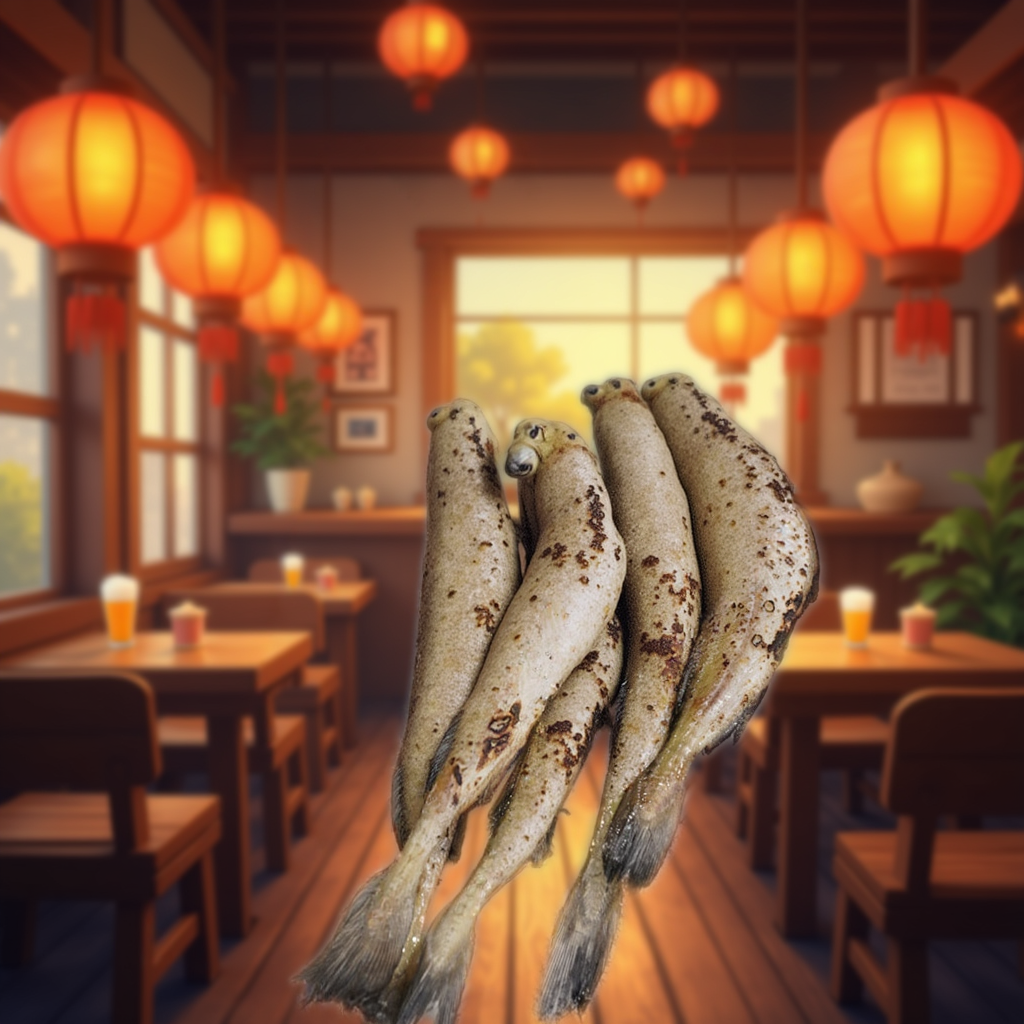

In [11]:

# 3. 노가리 이미지 로드 (배경 제거된 RGBA)
nogari_image = product_fg.convert("RGBA")
nogari_mask = nogari_image.split()[3]  # 알파 채널을 마스크로 사용

# 4. 노가리를 선명하게 유지하면서 배경에 합성
product_prompt = """
Photorealistic details of the input subject, razor-sharp focus on the product contrasting with a blurred cartoon style background. Professional food photography lighting, 8k resolution, masterpiece quality.
"""

final_image = fluxgenerator.inject_features_via_inpaint(
    background=bg_image,
    product_foreground=nogari_image,
    product_mask=nogari_mask,
    position=(200, 300),  # 배치 위치 조정
    prompt=product_prompt,
    negative_prompt="blurry product, soft focus product, cartoon fish, unrealistic",
    strength=0.3,  # 낮은 값 = 노가리 원본 유지
    guidance_scale=4.0,
    seed=42,
    auto_unload=False
)

fluxgenerator.unload()

#final_image.save("nogari_ad.png")
final_image.show()